In [152]:
import pandas as pd
import numpy as np
import os
import shutil
from collections import OrderedDict
from datetime import datetime, timedelta
import time
import math
import random

import matplotlib.pyplot as plt

from joblib import dump, load
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix

from scipy.stats import rankdata
from tabulate import tabulate

# Load Predictions Data

In [155]:
pred_file = './predictions/predictions.csv'
pred_df = pd.read_csv(pred_file)
pred_df.head()

,date,track_code,race_num,horse_name,entry,win,win_conf,h2h,odds
0,20180617,NPX,1,FLYING WINE,1,0.0,0.503984,3/5,12.0
1,20180617,NPX,1,LOCKED AND LOADED,2,1.0,0.659808,4/5,3.5
2,20180617,NPX,1,RED RHINO,3,0.0,0.517261,5/5,10.0
3,20180617,NPX,1,MYTHICAL WARRIOR,4,0.0,0.544216,2/5,8.0
4,20180617,NPX,1,MAKEAMERICAGRTAGIN,5,1.0,0.691036,0/5,1.4


# Load All Results Files

In [156]:
# Get all files
path = './results_files/'
results_files = [path + file for file in os.listdir(path) if file.endswith('.2')]

# File field mappings
results_map = OrderedDict({
    1: 'date',
    2: 'race_num',
    4: 'horse_name',
    30: 'rt_odds',
    59: 'finish_pos', 
})

# Parse files into dataframe
results_df = pd.DataFrame()
for ii, file in enumerate(results_files):
    # Open file to dataframe -- Take only columns that are necessary
    cols = [k for k in results_map.keys()]
    tmp_df = pd.read_csv(file, header=None)[cols]
    # Rename cols
    tmp_df.columns = [results_map[col] for col in tmp_df.columns]
    # Add track code
    track_code = file[-13:-10]
    tmp_df['track_code'] = track_code
    # Drop all horses who scratched/dnf
    tmp_df = tmp_df.loc[(tmp_df['finish_pos'] > 0) & (tmp_df['finish_pos'] != 92)]
    # Add these results to dataframe
    results_df = results_df.append(tmp_df)
    # Progress
    print('Processed Files: {}/{}'.format(ii+1, len(results_files)), end='\r', flush=True)
    
# Capitalize results horse names
results_df['horse_name'] = results_df['horse_name'].apply(lambda x: str(x).upper())
results_df.head()

,date,race_num,finish_pos,horse_name,rt_odds,track_code
0,20180729,1,1,LOU'S CHARDONNAY,3.15,SAR
1,20180729,1,2,PROMISES BROKEN,3.00,SAR
2,20180729,1,3,SUMMER PUNCH,2.15,SAR
3,20180729,1,4,TOUGH OLD BIRD,18.90,SAR
4,20180729,1,5,DREAM FEVER,3.30,SAR


# Merge Results with Predictions

In [157]:
master_df = pred_df.merge(results_df, 
                             left_on=['date', 'race_num', 'horse_name', 'track_code'],
                             right_on=['date', 'race_num', 'horse_name', 'track_code'])

# Rename odds to ML_odds
master_df = master_df.rename({'odds':'ml_odds'}, axis=1)

master_df.head()

,date,track_code,race_num,horse_name,entry,win,win_conf,h2h,ml_odds,finish_pos,rt_odds
0,20180617,NPX,1,FLYING WINE,1,0.0,0.503984,3/5,12.0,5,28.20
1,20180617,NPX,1,LOCKED AND LOADED,2,1.0,0.659808,4/5,3.5,4,2.35
2,20180617,NPX,1,RED RHINO,3,0.0,0.517261,5/5,10.0,1,3.00
3,20180617,NPX,1,MYTHICAL WARRIOR,4,0.0,0.544216,2/5,8.0,3,10.65
4,20180617,NPX,1,RUN AWAY LANE,6,1.0,0.655606,1/5,2.0,2,0.80


# Establish Rankings
Iterate through each race, and rank the horses based on various metrics. These rankings will be used to determine how we would have bet in these races if we had used these various metrics. The performance of the metrics will be used to determine an optimal betting strategy.

In [250]:
# Run through day/track combination
track_date_combos = master_df.groupby(['date','track_code']).size().reset_index()
ranked_df = pd.DataFrame()

# Iterate through each track/day
for ii, row in track_date_combos.iterrows():
    print('Processing Track/Date: {}/{}'.format(ii+1, len(track_date_combos)), end='\r', flush=True)
    # Create a separate table for each race
    track_code = row['track_code']
    date = row['date']
    track_df = master_df.loc[(master_df.date == date) & (master_df.track_code == track_code)]
    cols_to_keep = ['date','race_num', 'track_code', 'horse_name', 'entry',\
                    'win', 'win_conf','h2h', 'ml_odds', 'rt_odds']
    for num in range(1, track_df.race_num.max()+1):
        # Get data for this race
        race_df = track_df.loc[track_df['race_num'] == num][cols_to_keep]
        
        # Morning Line Ranking
        race_df['ml_rank'] = rankdata(race_df['ml_odds'], method='min')
        
        # Race Time Ranking
        race_df['rt_rank'] = rankdata(race_df['rt_odds'], method='min')
        
        # H2H Ranking -- convert string column to numeric
        race_df['h2h'] = race_df['h2h'].apply(lambda x: int(x[0]))
        race_df['h2h_rank'] = np.abs(rankdata(race_df['h2h'], method='min') - len(race_df['h2h'])) + 1
        
        # WIN Ranking -- need to sort by win then confidence. Horses projected to win will
        # be first in their confidence order, followed by the losers in reverse-confidence 
        # order. We reverse for losers, since those we are less confident will lose, are
        # implied to be more likely to win.
        winner_idx = race_df.loc[race_df['win'] == 1].index
        loser_idx = race_df.loc[race_df['win'] == 0].index
        sort_win_idx = race_df.loc[winner_idx].sort_values(['win_conf'], ascending=False).index
        sort_lose_idx = race_df.loc[loser_idx].sort_values(['win_conf'], ascending=True).index
        rank_idx = list(sort_win_idx) + list(sort_lose_idx)
        win_rank = pd.Series(range(len(rank_idx)), index=rank_idx) + 1        
        race_df['win_rank'] = win_rank
        
        #WIN/H2H Ranking -- will sort first by win, and then by h2h value
        win_h2h_df = race_df.sort_values(['win', 'h2h'], ascending=False)
        win_h2h_rank = pd.Series(range(len(win_h2h_df)), index=win_h2h_df.index) + 1
        race_df['win_h2h_rank'] = win_h2h_rank
        
        # Add ranked race df to ranked_df
        ranked_df = ranked_df.append(race_df)
        
# Drop all non-rank columns
drop_cols = ['win', 'win_conf', 'h2h', 'ml_odds', 'rt_odds', 'entry']
ranked_df = ranked_df.drop(drop_cols, axis=1)
ranked_df.head()

,date,race_num,track_code,horse_name,ml_rank,rt_rank,h2h_rank,win_rank,win_h2h_rank
2735,20180429,1,FON,I'M LUCKY,5,5,1,4,1
2736,20180429,1,FON,NEW TESTAMENT,4,4,2,2,2
2737,20180429,1,FON,HOLDING FAST,1,1,3,3,3
2738,20180429,1,FON,HEIR HORSE ONE,3,2,5,1,5
2739,20180429,1,FON,TIZAWONDERFULGIFT,2,3,4,5,4


# Get Toal Number of Races

In [262]:
total_races = 0

for ii, row in track_date_combos.iterrows():
    track_code = row['track_code']
    date = row['date']
    track_df = master_df.loc[(master_df.date == date) & (master_df.track_code == track_code)]
    for num in range(1, track_df.race_num.max()+1):
        total_races += 1
        
total_races

3586

# Create Betting DataFrame

In [625]:
betting_df = master_df.merge(ranked_df,
                            left_on=['date', 'race_num', 'track_code', 'horse_name'],
                            right_on=['date', 'race_num', 'track_code', 'horse_name'])

betting_df.head()

,date,track_code,race_num,horse_name,entry,win,win_conf,h2h,ml_odds,finish_pos,rt_odds,ml_rank,rt_rank,h2h_rank,win_rank,win_h2h_rank
0,20180617,NPX,1,FLYING WINE,1,0.0,0.503984,3/5,12.0,5,28.20,5,5,3,3,4
1,20180617,NPX,1,LOCKED AND LOADED,2,1.0,0.659808,4/5,3.5,4,2.35,2,2,2,1,1
2,20180617,NPX,1,RED RHINO,3,0.0,0.517261,5/5,10.0,1,3.00,4,3,1,4,3
3,20180617,NPX,1,MYTHICAL WARRIOR,4,0.0,0.544216,2/5,8.0,3,10.65,3,4,4,5,5
4,20180617,NPX,1,RUN AWAY LANE,6,1.0,0.655606,1/5,2.0,2,0.80,1,1,5,2,2


# Betting Params

In [808]:
win_bet_amt = 2 # Amt per bet
considered_horses = 2 # Horses to place bets on per race
conf_thresh = 0.6 # Confidence we'd like our win model to listen to prediction

# Bet According To ML Odds
If we did win bets on the top 3 horses every race, as projected by ML Odds, what would returns be?

In [831]:
# Get those horses who were ranked in top 3 by ML Odds
ml_bet_df = betting_df.loc[betting_df.ml_rank <= considered_horses]
ml_bet_df = ml_bet_df[['date', 'track_code', 'race_num', 'horse_name', 'finish_pos', 'ml_rank', 'rt_odds']]

# If horse won, payout is $bet_amt * rt_odds + $bet_amt, loss is -$bet_amt
ml_bet_df['bet_amt'] = win_bet_amt
ml_bet_df['payout'] = -win_bet_amt

# Only bet on horses with at least x-1 odds (to cover bets) where x is num of horses we're bettingn on
dont_bet_idx = ml_bet_df.loc[ml_bet_df.rt_odds < considered_horses].index
ml_bet_df.loc[dont_bet_idx, 'bet_amt'] = 0
ml_bet_df.loc[dont_bet_idx, 'payout'] = 0

win_idx = ml_bet_df.loc[ml_bet_df.finish_pos == 1].index
ml_bet_df.loc[win_idx, 'payout'] = ml_bet_df.loc[win_idx]['rt_odds'] * \
                                    ml_bet_df.loc[win_idx]['bet_amt'] + \
                                    ml_bet_df.loc[win_idx]['bet_amt']

# Show Df
ml_bet_df.head(5)

,date,track_code,race_num,horse_name,finish_pos,ml_rank,rt_odds,bet_amt,payout
1,20180617,NPX,1,LOCKED AND LOADED,4,2,2.35,2,-2.0
4,20180617,NPX,1,RUN AWAY LANE,2,1,0.80,0,0.0
6,20180617,NPX,2,COMMAND THE LAND,1,1,1.40,0,0.0
7,20180617,NPX,2,THE GREAT CAPER,2,2,3.50,2,-2.0
11,20180617,NPX,3,CELTIC LAD,3,2,1.15,0,0.0


# Bet According to RT Odds
If we did win bets on the top 3 horses every race, as projected by Race-Time Odds, what would returns be?

**This is our benchmark, as it represents what the general public predicts the best horses to be**

In [832]:
# Get those horses who were ranked in top 3 by RT Odds
rt_bet_df = betting_df.loc[betting_df.rt_rank <= considered_horses]
rt_bet_df = rt_bet_df[['date', 'track_code', 'race_num', 'horse_name', 'finish_pos', 'rt_rank', 'rt_odds']]

# If horse won, payout is $bet_amt * rt_odds + $bet_amt, loss is -$bet_amt
rt_bet_df['bet_amt'] = win_bet_amt
rt_bet_df['payout'] = -win_bet_amt

# Only bet on horses with at least 3-1 odds (to cover bets)
dont_bet_idx = rt_bet_df.loc[rt_bet_df.rt_odds < considered_horses].index
rt_bet_df.loc[dont_bet_idx, 'bet_amt'] = 0
rt_bet_df.loc[dont_bet_idx, 'payout'] = 0

win_idx = rt_bet_df.loc[rt_bet_df.finish_pos == 1].index
rt_bet_df.loc[win_idx, 'payout'] = rt_bet_df.loc[win_idx]['rt_odds'] * \
                                    rt_bet_df.loc[win_idx]['bet_amt'] + \
                                    rt_bet_df.loc[win_idx]['bet_amt']

# Show Df
rt_bet_df.head(5)

,date,track_code,race_num,horse_name,finish_pos,rt_rank,rt_odds,bet_amt,payout
1,20180617,NPX,1,LOCKED AND LOADED,4,2,2.35,2,-2.0
4,20180617,NPX,1,RUN AWAY LANE,2,1,0.80,0,0.0
6,20180617,NPX,2,COMMAND THE LAND,1,1,1.40,0,0.0
10,20180617,NPX,2,GOTTA GET LUCKY,4,2,3.45,2,-2.0
11,20180617,NPX,3,CELTIC LAD,3,1,1.15,0,0.0


# Bet According to WIN Model
If we did win bets on the top 3 horses every race, as projected by WIN Model, what would returns be?

In [833]:
# Get those horses who were ranked in top 3 by WIN
win_bet_df = betting_df.loc[betting_df.win_rank <= considered_horses]
win_bet_df = win_bet_df[['date', 'track_code', 'race_num', 'horse_name', 'finish_pos', 'win', 'win_conf', 'rt_rank', 'win_rank', 'rt_odds']]

# If horse won, payout is $bet_amt * rt_odds + $bet_amt, loss is -$bet_amt
win_bet_df['bet_amt'] = win_bet_amt
win_bet_df['payout'] = -win_bet_amt

# Don't bet on projected losers or weak confidence winners
dont_bet_idx = set(win_bet_df.loc[(win_bet_df.win != 1)].index)
dont_bet_idx = dont_bet_idx.union(set(win_bet_df.loc[(win_bet_df.win == 1) &
                                      (win_bet_df.win_conf < conf_thresh)].index))

# Only bet on horses with at least 3-1 odds (to cover bets)
dont_bet_idx = dont_bet_idx.union(set(win_bet_df.loc[win_bet_df.rt_odds < considered_horses].index))
win_bet_df.loc[dont_bet_idx, 'bet_amt'] = 0
win_bet_df.loc[dont_bet_idx, 'payout'] = 0

win_idx = win_bet_df.loc[win_bet_df.finish_pos == 1].index
win_bet_df.loc[win_idx, 'payout'] = win_bet_df.loc[win_idx]['rt_odds'] * \
                                    win_bet_df.loc[win_idx]['bet_amt'] + \
                                    win_bet_df.loc[win_idx]['bet_amt']

win_bet_df.head(5)

,date,track_code,race_num,horse_name,finish_pos,win,win_conf,rt_rank,win_rank,rt_odds,bet_amt,payout
1,20180617,NPX,1,LOCKED AND LOADED,4,1.0,0.659808,2,1,2.35,2,-2.0
4,20180617,NPX,1,RUN AWAY LANE,2,1.0,0.655606,1,2,0.80,0,0.0
6,20180617,NPX,2,COMMAND THE LAND,1,1.0,0.648386,1,1,1.40,0,0.0
7,20180617,NPX,2,THE GREAT CAPER,2,1.0,0.634065,3,2,3.50,2,-2.0
11,20180617,NPX,3,CELTIC LAD,3,1.0,0.650514,1,2,1.15,0,0.0


# Bet According to H2H Model
If we did win bets on the top 3 horses every race, as projected by Horse-to-Horse Model, what would returns be?

In [834]:
# Get those horses who were ranked in top 3 by H2H
h2h_bet_df = betting_df.loc[betting_df.h2h_rank <= considered_horses]
h2h_bet_df = h2h_bet_df[['date', 'track_code', 'race_num', 'horse_name', 'finish_pos', 'h2h_rank', 'rt_odds']]

# If horse won, payout is $bet_amt * rt_odds + $bet_amt, loss is -$bet_amt
h2h_bet_df['bet_amt'] = win_bet_amt
h2h_bet_df['payout'] = -win_bet_amt

# Only bet on horses with at least 3-1 odds (to cover bets)
dont_bet_idx = set(h2h_bet_df.loc[h2h_bet_df.rt_odds < considered_horses].index)

h2h_bet_df.loc[dont_bet_idx, 'bet_amt'] = 0
h2h_bet_df.loc[dont_bet_idx, 'payout'] = 0

win_idx = h2h_bet_df.loc[h2h_bet_df.finish_pos == 1].index
h2h_bet_df.loc[win_idx, 'payout'] = h2h_bet_df.loc[win_idx]['rt_odds'] * \
                                    h2h_bet_df.loc[win_idx]['bet_amt'] + \
                                    h2h_bet_df.loc[win_idx]['bet_amt']

h2h_bet_df.head(5)

,date,track_code,race_num,horse_name,finish_pos,h2h_rank,rt_odds,bet_amt,payout
1,20180617,NPX,1,LOCKED AND LOADED,4,2,2.35,2,-2.0
2,20180617,NPX,1,RED RHINO,1,1,3.00,2,8.0
5,20180617,NPX,2,THISISMYSTORY,5,1,7.00,2,-2.0
8,20180617,NPX,2,TIMELESS TALES,6,2,9.80,2,-2.0
15,20180617,NPX,3,CALL IT EVEN,4,2,11.75,2,-2.0


# Bet According to Win/H2H Model
If we did win bets on the top 3 horses every race, ranked first by their win score, and then by their h2h score, what would returns be?

In [835]:
# Get those horses who were ranked in top 3 by WIN/H2H combined
wh2h_bet_df = betting_df.loc[betting_df.win_h2h_rank <= considered_horses]
wh2h_bet_df = wh2h_bet_df[['date', 'track_code', 'race_num', 'horse_name', 'finish_pos', 'win', 'win_conf', 'win_h2h_rank', 'rt_odds']]

# If horse won, payout is $bet_amt * rt_odds + $bet_amt, loss is -$bet_amt
wh2h_bet_df['bet_amt'] = win_bet_amt
wh2h_bet_df['payout'] = -win_bet_amt

# Only bet on horses with at least x-1 odds (to cover bets)
dont_bet_idx = wh2h_bet_df.loc[wh2h_bet_df.rt_odds < considered_horses].index
# Don't Bet on horses who were not projected to win, or those who were not confidently projected to win
dont_bet_idx = dont_bet_idx.union(set(wh2h_bet_df.loc[wh2h_bet_df.win != 1].index))
dont_bet_idx = dont_bet_idx.union(set(wh2h_bet_df.loc[wh2h_bet_df.win_conf < conf_thresh].index))

wh2h_bet_df.loc[dont_bet_idx, 'bet_amt'] = 0
wh2h_bet_df.loc[dont_bet_idx, 'payout'] = 0

win_idx = wh2h_bet_df.loc[wh2h_bet_df.finish_pos == 1].index
wh2h_bet_df.loc[win_idx, 'payout'] = wh2h_bet_df.loc[win_idx]['rt_odds'] * \
                                    wh2h_bet_df.loc[win_idx]['bet_amt'] + \
                                    wh2h_bet_df.loc[win_idx]['bet_amt']

wh2h_bet_df.head(5)

,date,track_code,race_num,horse_name,finish_pos,win,win_conf,win_h2h_rank,rt_odds,bet_amt,payout
1,20180617,NPX,1,LOCKED AND LOADED,4,1.0,0.659808,1,2.35,2,-2.0
4,20180617,NPX,1,RUN AWAY LANE,2,1.0,0.655606,2,0.80,0,0.0
5,20180617,NPX,2,THISISMYSTORY,5,1.0,0.616664,1,7.00,2,-2.0
6,20180617,NPX,2,COMMAND THE LAND,1,1.0,0.648386,2,1.40,0,0.0
14,20180617,NPX,3,LIVE A LITTLE,1,1.0,0.684547,2,4.55,2,11.1


# Find Number of Hits per Strategy
Count how many times we pick a winner using each strategy

In [836]:
ml_win_count = np.sum(ml_bet_df['payout'].apply(lambda x: 1 if x>0 else 0))
rt_win_count = np.sum(rt_bet_df['payout'].apply(lambda x: 1 if x>0 else 0))
win_win_count = np.sum(win_bet_df['payout'].apply(lambda x: 1 if x>0 else 0))
h2h_win_count = np.sum(h2h_bet_df['payout'].apply(lambda x: 1 if x>0 else 0))
wh2h_win_count = np.sum(wh2h_bet_df['payout'].apply(lambda x: 1 if x>0 else 0))

ml_win_count, rt_win_count, win_win_count, h2h_win_count, wh2h_win_count

(797, 853, 517, 547, 343)

In [837]:
# Find hits that weren't predicted by general public
rt_hits = rt_bet_df.loc[rt_bet_df.payout > 0]
rt_dates = rt_hits.groupby(['date', 'track_code', 'race_num']).size().reset_index()

# Go through win bets and take out all races whose date/track/race match rt bets
overlap_idx = []
for row in rt_dates.iterrows():
    row = row[1]
    date = row.date
    tc = row.track_code
    race = row.race_num
    
    # Add overlapping entries to index
    overlap_idx += list(win_bet_df.loc[(win_bet_df.date == date) & 
                                       (win_bet_df.track_code == tc) &
                                       (win_bet_df.race_num == race)].index)
    
non_overlap_idx = list(set(win_bet_df.index) - set(overlap_idx))
win_diff = win_bet_df.loc[non_overlap_idx].loc[win_bet_df.payout > 0]

In [838]:
# Get all hit payouts
ml_payouts = ml_bet_df.loc[ml_bet_df.payout > 0]['payout']
rt_payouts = rt_bet_df.loc[rt_bet_df.payout > 0]['payout']
win_payouts = win_bet_df.loc[win_bet_df.payout > 0]['payout']
h2h_payouts = h2h_bet_df.loc[h2h_bet_df.payout > 0]['payout']
wh2h_payouts = wh2h_bet_df.loc[wh2h_bet_df.payout > 0]['payout']

# Get average payouts per hit
ml_avg_payout = np.mean(ml_payouts)
rt_avg_payout = np.mean(rt_payouts)
win_avg_payout = np.mean(win_payouts)
h2h_avg_payout = np.mean(h2h_payouts)
wh2h_avg_payout = np.mean(wh2h_payouts)

# Get Variance for Payouts on hits
ml_std_payout = np.std(ml_payouts)
rt_std_payout = np.std(rt_payouts)
win_std_payout = np.std(win_payouts)
h2h_std_payout = np.std(h2h_payouts)
wh2h_std_payout = np.std(wh2h_payouts)

print('ML Payout Avg/STD: {} | {}'.format(ml_avg_payout, ml_std_payout))
print('RT Payout Avg/STD: {} | {}'.format(rt_avg_payout, rt_std_payout))
print('WIN Payout Avg/STD: {} | {}'.format(win_avg_payout, win_std_payout))
print('H2H Payout Avg/STD: {} | {}'.format(h2h_avg_payout, h2h_std_payout))
print('WIN/H2H Payout Avg/STD: {} | {}'.format(wh2h_avg_payout, wh2h_std_payout))

ML Payout Avg/STD: 8.811166875784183 | 3.0363524423368107
RT Payout Avg/STD: 7.786635404454858 | 1.9763097645847283
WIN Payout Avg/STD: 10.763249516440998 | 6.080539675734919
H2H Payout Avg/STD: 16.064168190127962 | 14.245767689689595
WIN/H2H Payout Avg/STD: 11.723323615160353 | 8.249476246486037


# Get Cumulative Returns for Each Betting Style

In [839]:
#Df for cumulative returns
idx = pd.date_range(start='4/29/2018', end='11/03/2018')
rets_df = pd.DataFrame(index=idx, columns=['ml_ret', 'rt_ret', 'win_ret', 'h2h_ret', 'win_h2h_ret'])

# Convert date strings to dates
ml_bet_df['date'] = ml_bet_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
rt_bet_df['date'] = rt_bet_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
win_bet_df['date'] = win_bet_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
h2h_bet_df['date'] = h2h_bet_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
wh2h_bet_df['date'] = wh2h_bet_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))

# Group each DF by Date
ml_bet_df = ml_bet_df.groupby(['date']).sum()
rt_bet_df = rt_bet_df.groupby(['date']).sum()
win_bet_df = win_bet_df.groupby(['date']).sum()
h2h_bet_df = h2h_bet_df.groupby(['date']).sum()
wh2h_bet_df = wh2h_bet_df.groupby(['date']).sum()

# Get cumulative returns
ml_bet_df['cum_ret'] = np.cumsum(ml_bet_df.payout)
rt_bet_df['cum_ret'] = np.cumsum(rt_bet_df.payout)
win_bet_df['cum_ret'] = np.cumsum(win_bet_df.payout)
h2h_bet_df['cum_ret'] = np.cumsum(h2h_bet_df.payout)
wh2h_bet_df['cum_ret'] = np.cumsum(wh2h_bet_df.payout)

# Join cumulative returns to cumulative returns df
rets_df.loc[ml_bet_df.index, 'ml_ret'] = ml_bet_df['cum_ret']
rets_df.loc[rt_bet_df.index, 'rt_ret'] = rt_bet_df['cum_ret']
rets_df.loc[win_bet_df.index, 'win_ret'] = win_bet_df['cum_ret']
rets_df.loc[h2h_bet_df.index, 'h2h_ret'] = h2h_bet_df['cum_ret']
rets_df.loc[wh2h_bet_df.index, 'win_h2h_ret'] = wh2h_bet_df['cum_ret']

# Forward Fill Nan Values
rets_df.fillna(method='ffill', inplace=True)

# Print out cumulative returns for all strategies
ml_returns = round(rets_df.iloc[-1].ml_ret, 2)
rt_returns = round(rets_df.iloc[-1].rt_ret, 2)
win_returns = round(rets_df.iloc[-1].win_ret, 2)
h2h_returns = round(rets_df.iloc[-1].h2h_ret, 2)
wh2h_returns = round(rets_df.iloc[-1].win_h2h_ret, 2)


print('ML Returns: {}'.format(ml_returns))
print('RT Returns: {}'.format(rt_returns))
print('WIN Returns: {}'.format(win_returns))
print('H2H Returns: {}'.format(h2h_returns))
print('WIN/H2H Returns: {}'.format(wh2h_returns))

ML Returns: -449.5
RT Returns: 270.0
WIN Returns: -31.4
H2H Returns: -2878.9
WIN/H2H Returns: 411.1


# Plot Cumulative Returns of All Strategies

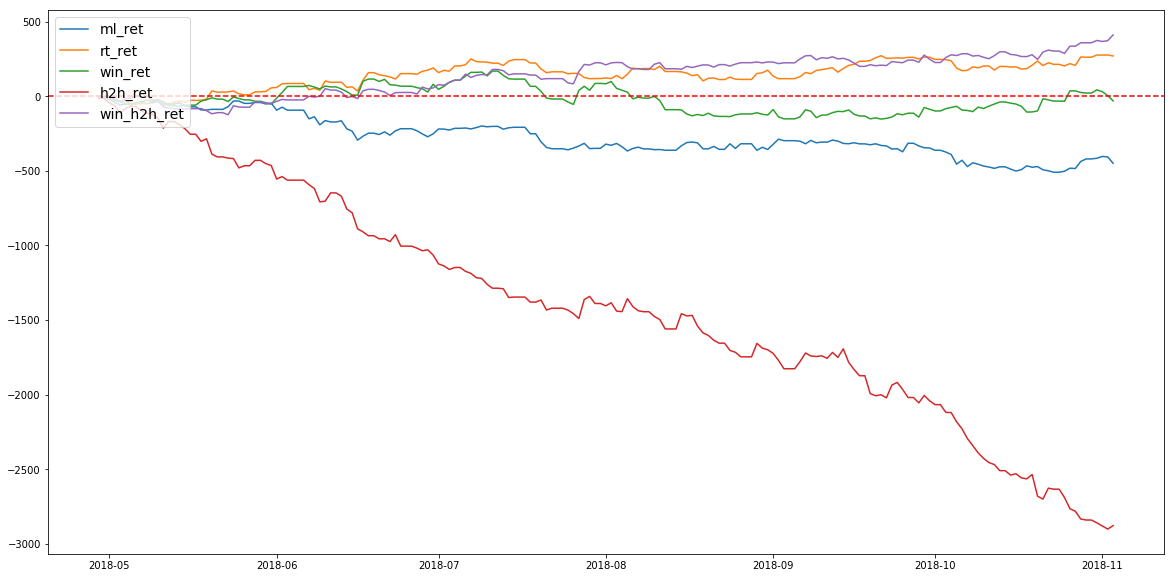

In [840]:
plt.figure(figsize=(20,10))

plt.plot(rets_df.index, rets_df.ml_ret)
plt.plot(rets_df.index, rets_df.rt_ret)
plt.plot(rets_df.index, rets_df.win_ret)
plt.plot(rets_df.index, rets_df.h2h_ret)
plt.plot(rets_df.index, rets_df.win_h2h_ret)

plt.legend(loc=2, prop={'size': 14})
plt.axhline(y=0, color='r', linestyle='--')
plt.show()